In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import pickle

import sys
sys.path.append("../../../assets")
sys.path.append("../")
from experiments import NonStationaryDDMExperiment
from models import MixtureRandomWalkDDM, RegimeSwitchingDDM, RandomWalkDDM, LevyFlightDDM

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
%load_ext autoreload
%autoreload 2
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

In [5]:
NUM_OBS = 768
NUM_SAMPLES = 2000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
CONDITION_NAMES = ["Accuracy Condition", "Speed Condition"]
YLABEL = [
    "Response time (s)", "Response time (s)", "Accuracy", "Accuracy",
    "Drift rate", "Drift rate", "Threshold", "Threshold"
    ]
BAR_WIDTH = np.arange(-0.5, 0.7, 0.25)
X_AXIS_VALUES = np.arange(4) * 1.5
LABELS = [
    'Empiric', 'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]
COLORS = [
    "black", "orange", "maroon", "#133a76", "green"
]

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [6]:
rw_model = RandomWalkDDM()
rw_trainer = NonStationaryDDMExperiment(
    rw_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_random_walk_ddm",
    skip_checks=True
)

mrw_model = MixtureRandomWalkDDM()
mrw_trainer = NonStationaryDDMExperiment(
    mrw_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm",
    skip_checks=True
)

lf_model = LevyFlightDDM()
lf_trainer = NonStationaryDDMExperiment(
    lf_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_levy_flight_ddm",
    skip_checks=True
)

rs_model = RegimeSwitchingDDM()
rs_trainer = NonStationaryDDMExperiment(
    rs_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_regime_switching_ddm",
    skip_checks=True
)

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_random_walk_ddm/ckpt-75
INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 

In [7]:
models = [rw_model, mrw_model, lf_model, rs_model]
trainers = [rw_trainer, mrw_trainer, lf_trainer, rs_trainer]

## Prepare Data

In [8]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

data['trial'] = np.tile(np.arange(NUM_OBS) + 1, NUM_SUBJECTS)
data['rt'] = np.abs(data['rt'])

In [9]:
def model_inference(model, trainer, max_obs):
    num_local_params = model.local_prior_means.shape[0]
    local_samples_z = np.zeros((NUM_SUBJECTS, max_obs, NUM_SAMPLES, num_local_params))
    with tf.device('/cpu:0'):
        for i in range(NUM_SUBJECTS):
            subject_data = {'summary_conditions': emp_data[i:i+1, :max_obs]}
            samples = trainer.amortizer.sample(subject_data, NUM_SAMPLES)
            local_samples_z[i] = samples['local_samples']
    local_samples = local_samples_z * model.local_prior_stds + model.local_prior_means
    return local_samples

## Inference

In [10]:
MAX_OBS = [int(NUM_OBS*(1/8)), int(NUM_OBS*(1/4)), int(NUM_OBS*(1/2))]

In [11]:
samples_per_ablation = []
for max_obs in MAX_OBS:
    samples_per_model = []
    for i in tqdm(range(len(models))):
        samples = model_inference(models[i], trainers[i], max_obs)
        samples_per_model.append(samples)
    samples_per_ablation.append(samples_per_model)

100%|██████████| 4/4 [16:13<00:00, 243.28s/it]


## Evaluation

In [12]:
def plot_result_summary(summaries, max_obs, figsize=(18, 8)):
    FONT_SIZE_1 = 22
    FONT_SIZE_2 = 21
    FONT_SIZE_3 = 18
    handles = []
    fig, axarr = plt.subplots(2, 4, figsize=figsize)
    which_summary = np.repeat(np.arange(4), 2)
    which_condition = np.tile([0, 1], 4)
    for i, ax in enumerate(axarr.flat):
        summary = summaries[which_summary[i]]
        if i < 4:
            colors = ["black", "orange", "maroon", "#133a76", "green"]
        else:
            colors = ["orange", "maroon", "#133a76", "green"]
        for t, sumsum in enumerate(summary):
            ax.scatter(
                X_AXIS_VALUES + BAR_WIDTH[t],
                sumsum.loc[sumsum.speed_condition == which_condition[i], 'point_estimate'],
                s=75, color=colors[t], label=LABELS[t]
            )
            ax.errorbar(
                X_AXIS_VALUES + BAR_WIDTH[t],
                sumsum.loc[sumsum.speed_condition == which_condition[i], 'point_estimate'],
                yerr=sumsum.loc[sumsum.speed_condition == which_condition[i], 'error'],
                fmt='o', color=colors[t], markersize=8, elinewidth=2, capsize=0
                )
            handles.append(
                Line2D(
                    xdata=[], ydata=[], marker='o', markersize=10, lw=3,
                    color=colors[t], label=LABELS[t]
                )
            )
        ax.set_title(CONDITION_NAMES[which_condition[i]], pad=20, fontsize=FONT_SIZE_1)
        x_labels = ['1', '2', '3', '4']
        x_positions = X_AXIS_VALUES
        ax.set_xticks(x_positions, x_labels)
        if i < 2:
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 0.1,
                summary[0]["point_estimate"].max() + 0.4
                ])
        elif i < 4:
            ax.set_ylim([0.4, 1.05])
        elif i < 6:
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 1.0,
                summary[0]["point_estimate"].max() + 2.5
                ])
        else:
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 0.25,
                summary[0]["point_estimate"].max() + 0.4
                ])
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_ylabel(YLABEL[i], labelpad=10, fontsize=FONT_SIZE_2)
        if i > 3:
            ax.set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)
        ax.grid(alpha=0.4)
    # legend
    fig.subplots_adjust(hspace=0.5)
    fig.legend(
        handles,
        LABELS,
        fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
        loc="center", ncol=5
        )
    sns.despine()
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    fig.suptitle(f'N = {max_obs}', fontsize=26, fontweight='semibold', y=1.05)
    return fig

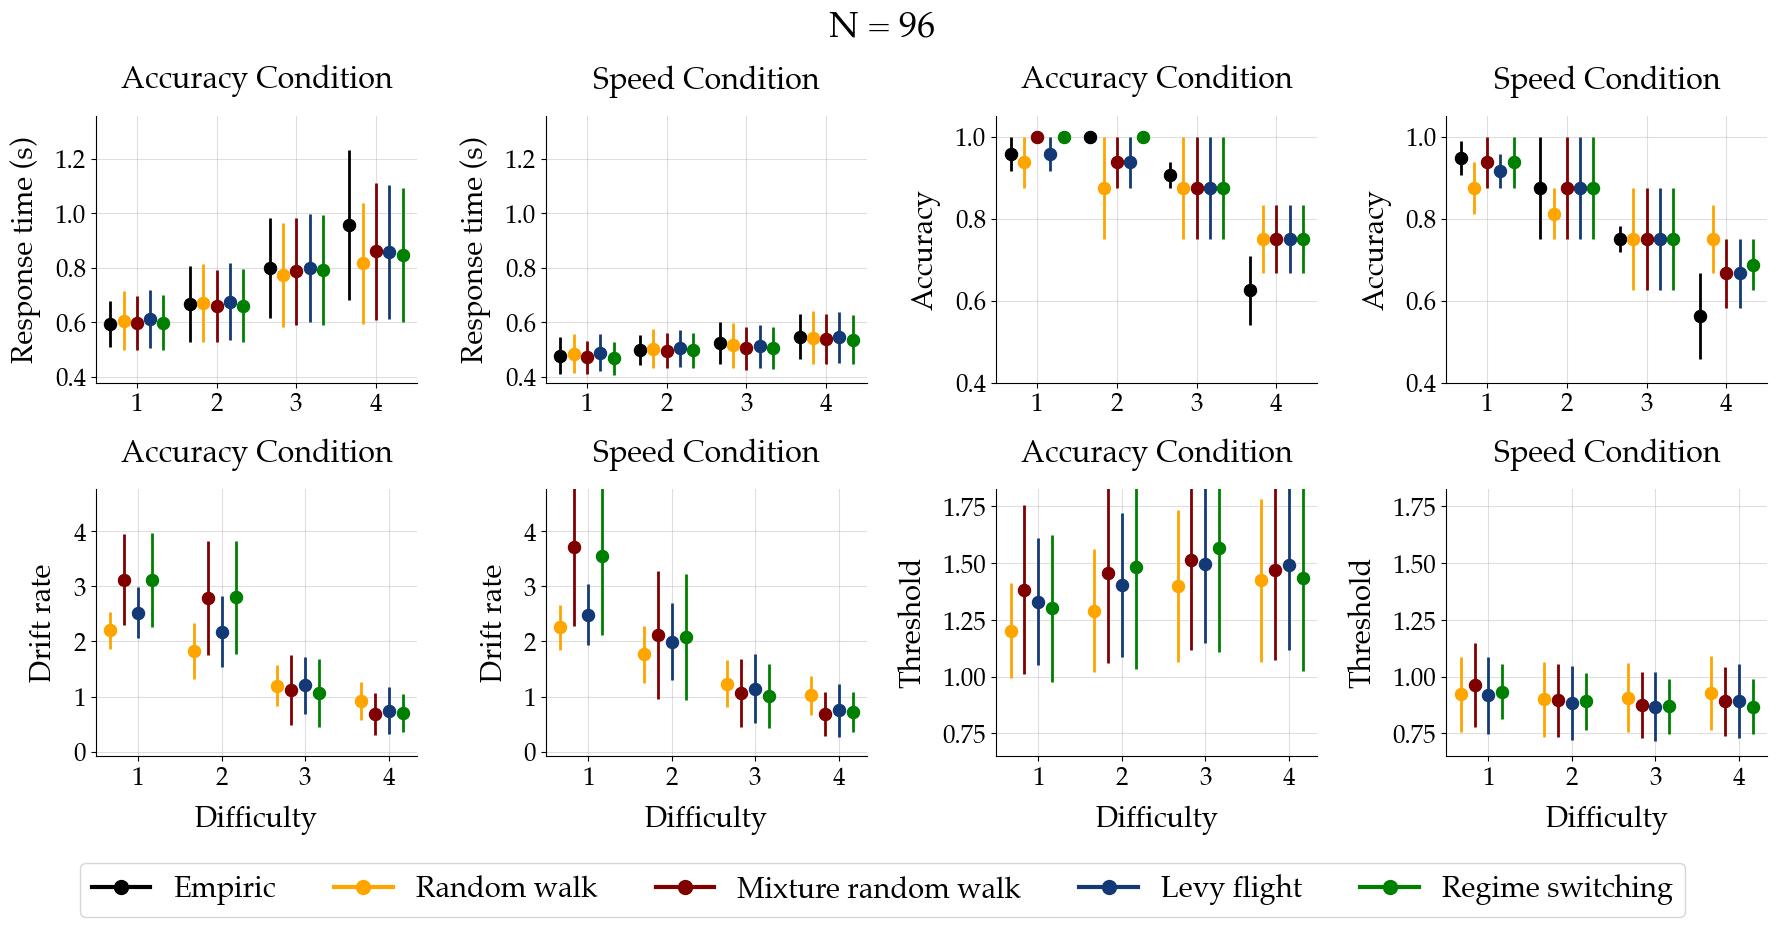

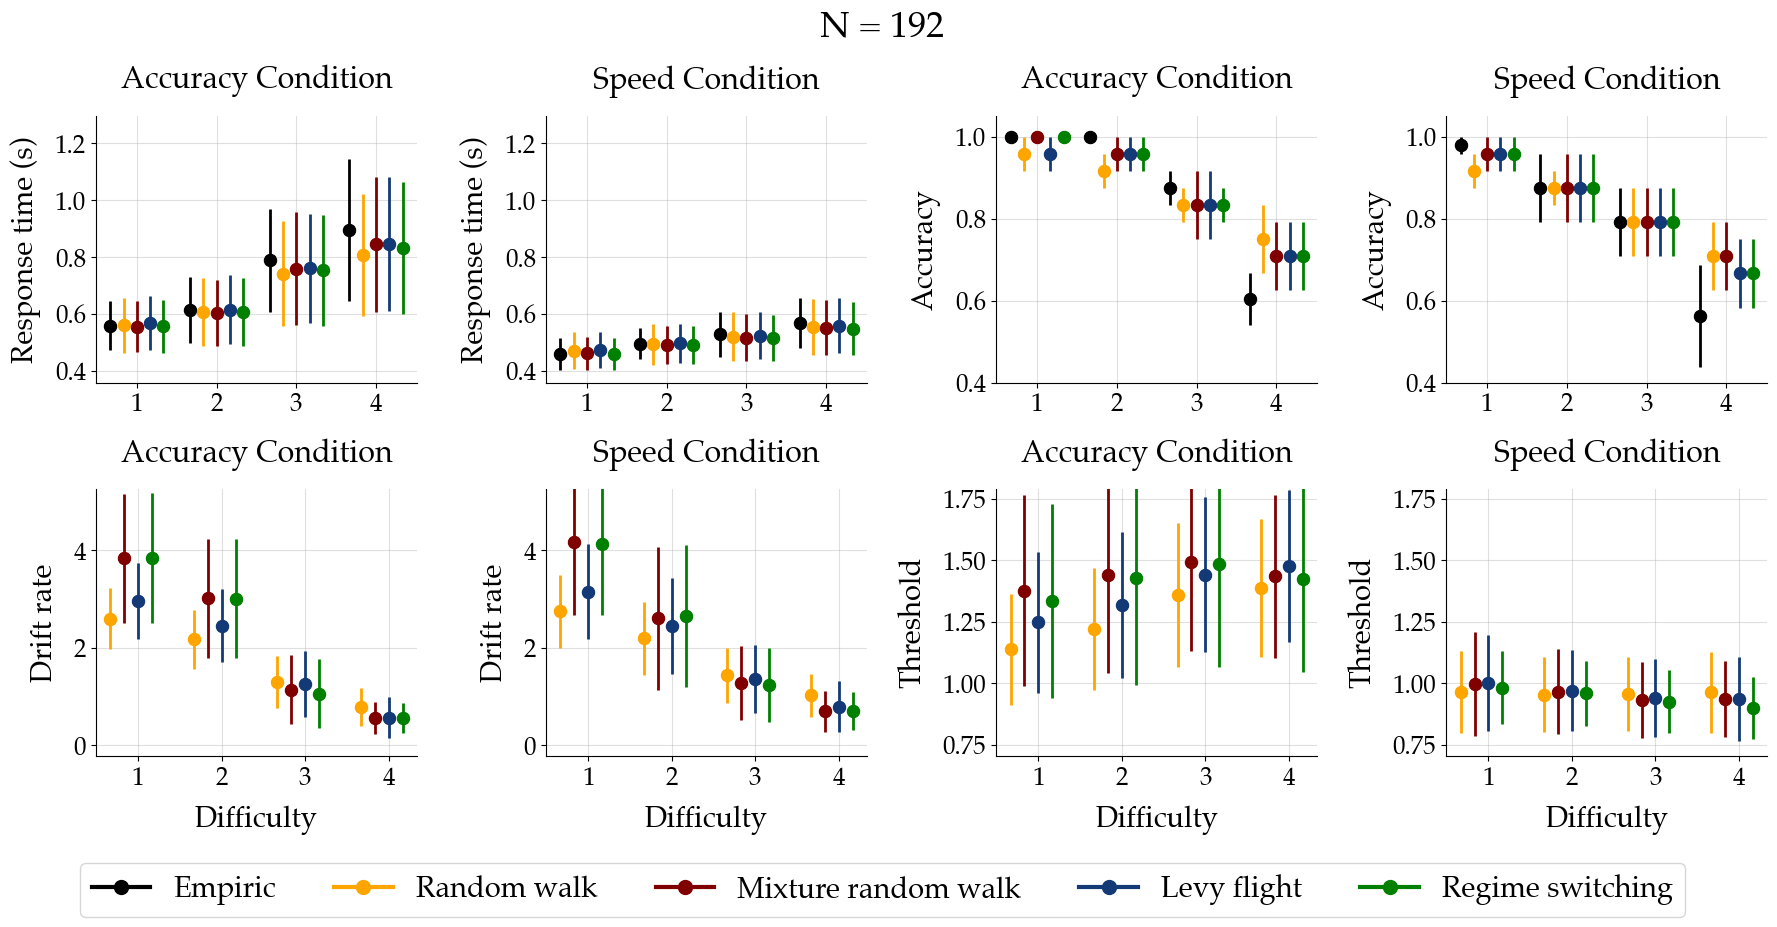

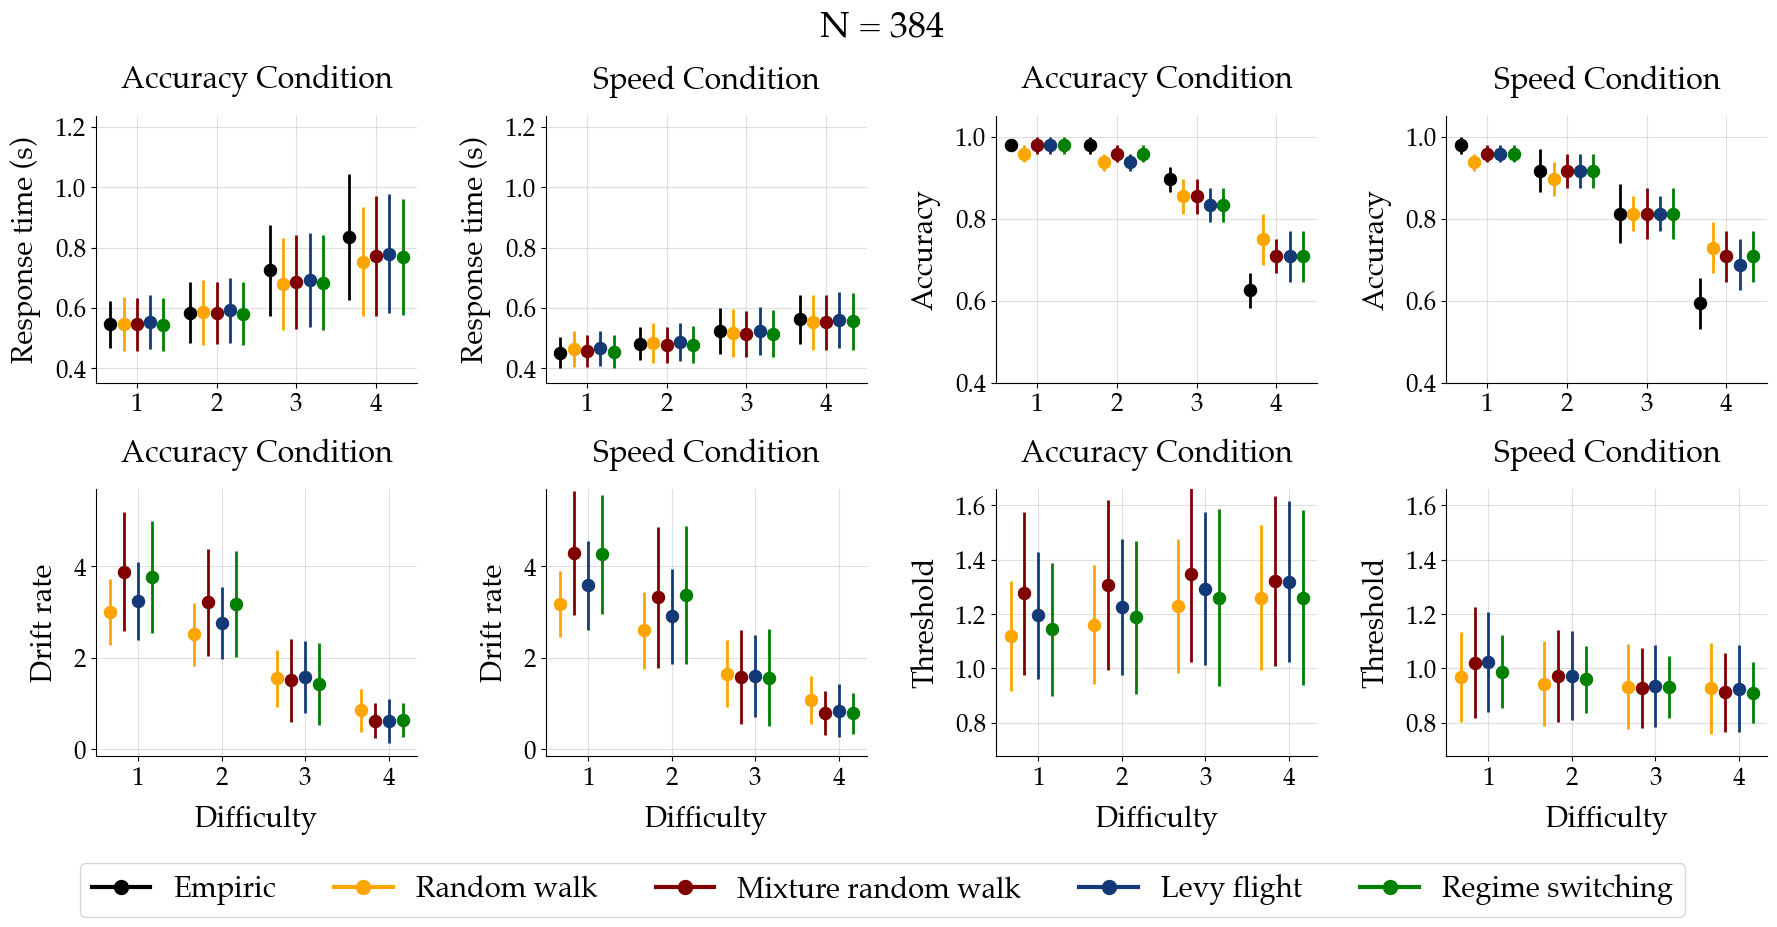

In [13]:
for j, max_obs in enumerate(MAX_OBS):
    sub_data = data[data.trial <= MAX_OBS[j]]
    # compute overall empiric rt summaries
    grouped_data = sub_data.groupby(['speed_condition', 'difficulty'])
    rt_summary = grouped_data.agg({
        'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    }).reset_index(drop=False)
    rt_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    # compute overall empiric acc summaries
    grouped_data = sub_data.groupby(['id', 'speed_condition', 'difficulty'])
    acc_summary = grouped_data.agg({
        'correct': ['mean']
    }).reset_index(drop=False)
    acc_summary.columns = ['id', 'speed_condition', 'difficulty', 'accuracy']
    grouped_data = acc_summary.groupby(['speed_condition', 'difficulty'])
    acc_summary = grouped_data.agg({
        'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    }).reset_index(drop=False)
    acc_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']

    # iterate over model and subjects
    rt_summary_per_model = []
    acc_summary_per_model = []
    v_summary_per_model = []
    a_summary_per_model = []
    resim_data_per_model = []
    posteriors_per_model = []
    rt_summary_per_model.append(rt_summary)
    acc_summary_per_model.append(acc_summary)

    for i, model in enumerate(models):
        resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, max_obs, 6))
        person_samples = np.zeros((NUM_SUBJECTS, max_obs, NUM_SAMPLES, 5))
        for sub in range(NUM_SUBJECTS):
            # compute indiviudal summaries
            person_data = sub_data.loc[sub_data.id == sub+1]
            # posterior re-simulation for all models
            idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
            pred_data = model.likelihood(samples_per_ablation[j][i][sub, :, idx, :])['sim_data']
            pred_rt = np.abs(pred_data[:, :, None])
            pred_correct = np.where(np.sign(pred_data) == -1, 0, 1)[:, :, None]
            condition = np.tile(person_data['speed_condition'], (NUM_RESIMULATIONS, 1))[:, :, None]
            difficulty = np.tile(person_data['difficulty'], (NUM_RESIMULATIONS, 1))[:, :, None]
            id = np.full((NUM_RESIMULATIONS, max_obs, 1), sub+1)
            sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), max_obs).reshape((NUM_RESIMULATIONS, max_obs, 1))
            resim_data[sub] = np.c_[id, sim_seq, pred_rt, pred_correct, condition, difficulty]
        resim_data_per_model.append(resim_data)
        # summarize drift rate and threshold posterior
        samples = samples_per_ablation[j][i]
        difficulty = sub_data.difficulty.to_numpy().reshape((14, max_obs, 1))
        difficulty = np.repeat(difficulty, 2000, axis=2)[:, :, :, np.newaxis]
        condition = sub_data.speed_condition.to_numpy().reshape((14, max_obs, 1))
        condition = np.repeat(condition, 2000, axis=2)[:, :, :, np.newaxis]
        samples = np.c_[condition, difficulty, samples]
        reshaped_data = samples.reshape(-1, 5)
        df = pd.DataFrame(reshaped_data, columns=['speed_condition', 'difficulty', 'v', 'a', 'tau'])
        grouped_data = df.groupby(['speed_condition', 'difficulty'])
        summary = grouped_data.agg({
            'v': ['median', lambda x: np.median(np.abs(x - np.median(x)))],
            'a': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
        }).reset_index(drop=False)
        summary.columns = ['speed_condition', 'difficulty', 'v_median', 'v_mad', 'a_median', 'a_mad']
        v_summary = summary[['speed_condition', 'difficulty', 'v_median', 'v_mad']]
        v_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
        a_summary = summary[['speed_condition', 'difficulty', 'a_median', 'a_mad']]
        a_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
        v_summary_per_model.append(v_summary)
        a_summary_per_model.append(a_summary)
        # overall re-simulation
        reshaped_data = resim_data.reshape(-1, 6)
        df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'correct', 'speed_condition', 'difficulty'])
        # summarize rts
        grouped_data = df.groupby(['speed_condition', 'difficulty'])
        summary = grouped_data.agg({
            'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
        })
        summary = summary.reset_index(drop=False)
        summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
        rt_summary_per_model.append(summary)
        # summarize accuracy
        grouped_data = df.groupby(['id', 'sim', 'speed_condition', 'difficulty'])
        summary = grouped_data.agg({
            'correct': ['mean']
        }).reset_index(drop=False)
        summary.columns = ['id', 'sim', 'speed_condition', 'difficulty', 'accuracy']
        grouped_data = summary.groupby(['speed_condition', 'difficulty'])
        summary = grouped_data.agg({
            'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
        }).reset_index(drop=False)
        summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
        acc_summary_per_model.append(summary)
    summary_list = [rt_summary_per_model, acc_summary_per_model, v_summary_per_model, a_summary_per_model]
    f = plot_result_summary(summary_list, max_obs)
    f.savefig(f"../plots/ablation_results_n_{max_obs}.pdf", dpi=300, bbox_inches="tight")